# Multimodal Transformer Model - MOSEI

In this notebook, we implement the MulT Model (Multimodal Transformer for Unaligned Multimodal Language Sequences), and test it on CMU-MOSEI dataset.

## Importing Libraries

In [1]:
import os
import sys
import torch

import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

## Importing Helper Functions

In [2]:
from helpers.data.get_data import get_dataloader
from helpers.unimodals.common_models import Identity, MLP
from helpers.fusions.mult import MULTModel
from helpers.fusions.common_fusions import Concat
from helpers.training.supervised_learning import train, test
from helpers.utils.common_utils import get_default_device, save_results

## Loading the Dataset

In [3]:
traindata, validdata, testdata = get_dataloader('/scratch/rrm9598/data/mosei_senti_data.pkl', robust_test=False, max_pad=True)

In [4]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [5]:
class HParams():
    num_heads = 8
    layers = 4
    attn_dropout = 0.1
    attn_dropout_modalities = [0, 0, 0.1]
    relu_dropout = 0.1
    res_dropout = 0.1
    out_dropout = 0.1
    embed_dropout = 0.2
    embed_dim = 40
    attn_mask = True
    output_dim = 1
    all_steps = False

In [6]:
encoders = [
    Identity().to(device), 
    Identity().to(device), 
    Identity().to(device),
]

fusion = MULTModel(3, [35, 74, 300], hyp_params=HParams).to(device)

head = Identity().to(device)

## Training

In [7]:
FILE_NAME = 'mosei_mult_r0'

In [8]:
train_losses, valid_losses = train(
    encoders, fusion, head, traindata, validdata, 30, 
    task="regression", optimtype=torch.optim.AdamW, early_stop=False, is_packed=False, 
    lr=1e-3, clip_val=1.0, save=f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt', 
    weight_decay=0.01, objective=torch.nn.L1Loss())

Epoch [1/30]
Train Loss: 0.7963
Valid Loss: 0.6683
Saving Best

Epoch [2/30]
Train Loss: 0.6871
Valid Loss: 0.7132

Epoch [3/30]
Train Loss: 0.6522
Valid Loss: 0.7173

Epoch [4/30]
Train Loss: 0.6392
Valid Loss: 0.6266
Saving Best

Epoch [5/30]
Train Loss: 0.6247
Valid Loss: 0.6145
Saving Best

Epoch [6/30]
Train Loss: 0.6189
Valid Loss: 0.6098
Saving Best

Epoch [7/30]
Train Loss: 0.6102
Valid Loss: 0.6286

Epoch [8/30]
Train Loss: 0.6031
Valid Loss: 0.5895
Saving Best

Epoch [9/30]
Train Loss: 0.5980
Valid Loss: 0.6138

Epoch [10/30]
Train Loss: 0.5906
Valid Loss: 0.6212

Epoch [11/30]
Train Loss: 0.5852
Valid Loss: 0.5973

Epoch [12/30]
Train Loss: 0.5809
Valid Loss: 0.5993

Epoch [13/30]
Train Loss: 0.5767
Valid Loss: 0.5952

Epoch [14/30]
Train Loss: 0.5670
Valid Loss: 0.6013

Epoch [15/30]
Train Loss: 0.5663
Valid Loss: 0.6039

Epoch [16/30]
Train Loss: 0.5583
Valid Loss: 0.6230

Epoch [17/30]
Train Loss: 0.5559
Valid Loss: 0.6338

Epoch [18/30]
Train Loss: 0.5509
Valid Loss: 0.6

Text(0.5, 1.0, 'Loss vs. No. of epochs')

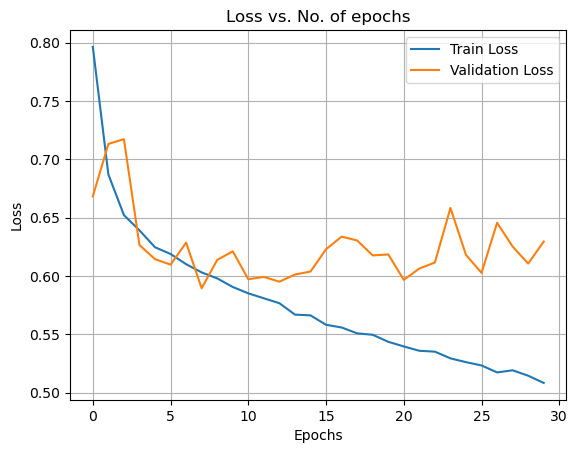

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [10]:
save_results(train_losses, valid_losses, f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/results/{FILE_NAME}.pkl')

## Testing

In [11]:
model = torch.load(f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt').to(device)

test(model, test_dataloaders_all=testdata, dataset='mosi', is_packed=False,
     criterion=torch.nn.L1Loss(), task='posneg-classification', no_robust=True)

Recall: 80.6354% | Total Accuracy: 68.5979%
Inference Time: 8s418ms
Inference Params: 3080321
